<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>


## Waveforms for two different modes close to coastal features ##

As part of Copernicus, EUMETSAT operates the Poseidon-4 altimeter on Sentinel-6.

Waveforms are the fundamental signal that altimeters receive, and from which they derive all their information about the ocean surface. The shape of a waveform is determined by how a radar pulse interacts with the Earth's surface. Much more information on waveforms can be found here:

http://www.altimetry.info/radar-altimetry-tutorial/how-altimetry-works/from-radar-pulse-to-altimetry-measurements/

In [1]:
import os
#import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy

In [2]:
#we will look at the plot within the notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()
matplotlib.rcParams.update({'font.size': 16})

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [3]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
#MYPATH = os.cwd()
MYPATH = ''

We will read and extract data from the L1B files. 
Note that you can have a look before at the L2 file, to check the direction of the track (south pole to north or the reverse), and also to check if the tide is not very low - in this particular case, measurements could be on wet sand rather than water at very low tides. Those variables are provided within the L2 file, not the L1B for S6.

In [4]:
input_root = os.path.join(MYPATH,'data')
input_path = ''
input_file = 'S6A_P4_1B_LR______20220410T013454_20220410T023107_20220522T101118_3373_052_070_035_EUM__REP_NT_F06.measurement.nc'

#since we consider looking at both versions of the file, we define "resolution" as HR or LR (to be used twice later on)
resolution = input_file[10:12]

my_file    = os.path.join(input_root,input_path,input_file)
nc = xr.open_dataset(my_file)
nc20ku = xr.open_dataset(my_file, group='data_20/ku')

if resolution=='HR':
    varsamp='samples_ov'
else:
    varsamp='samples'

samples = nc.variables[varsamp]
lat_20_fulltrack = nc20ku.variables['latitude']
lon_20_fulltrack = nc20ku.variables['longitude']

Extract data only in the lon/lat box searched

In [5]:
# fort Boyard 46°N, -1.214°E;
lon_min = 360-1.3; lat_min = 45.9; lon_max= 360-1.1; lat_max = 46.1;

subsetnc20ku = nc20ku.sel(time=((lon_20_fulltrack > lon_min) & (lon_20_fulltrack < lon_max) & (lat_20_fulltrack > lat_min) & (lat_20_fulltrack < lat_max)))
nc20ku.close()

lat_20 = subsetnc20ku.variables['latitude']
lon_20 = subsetnc20ku.variables['longitude']
time = subsetnc20ku.variables['time']
waveforms_20hz_ku = subsetnc20ku.variables['power_waveform']

Plot of the track, to have a look at where we are (enlarge the set_extent to have a broader view)

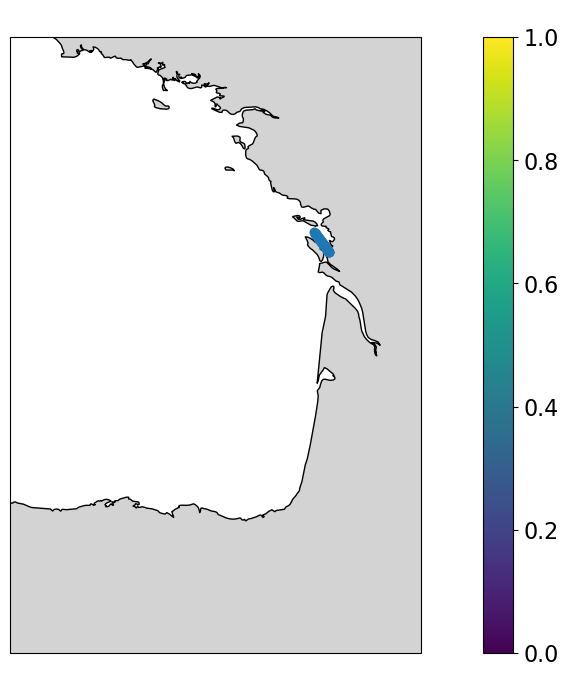

In [6]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([-5, 0, 42, 48], crs=ccrs.PlateCarree())
#ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# plot the data on a map
tracks = ax.scatter(lon_20, lat_20)
cbar = plt.colorbar(tracks)
plt.title(' ', size=18)
plt.show()

We will plot the waveforms' power as a color plot along time and samples
Note that we could have used pcolormesh for this and would not have needed the meshgrid regridding, but we will need the scatter plotting afterwards and it would not have worked if the three x, y and c do not have the exact same dimensions. 

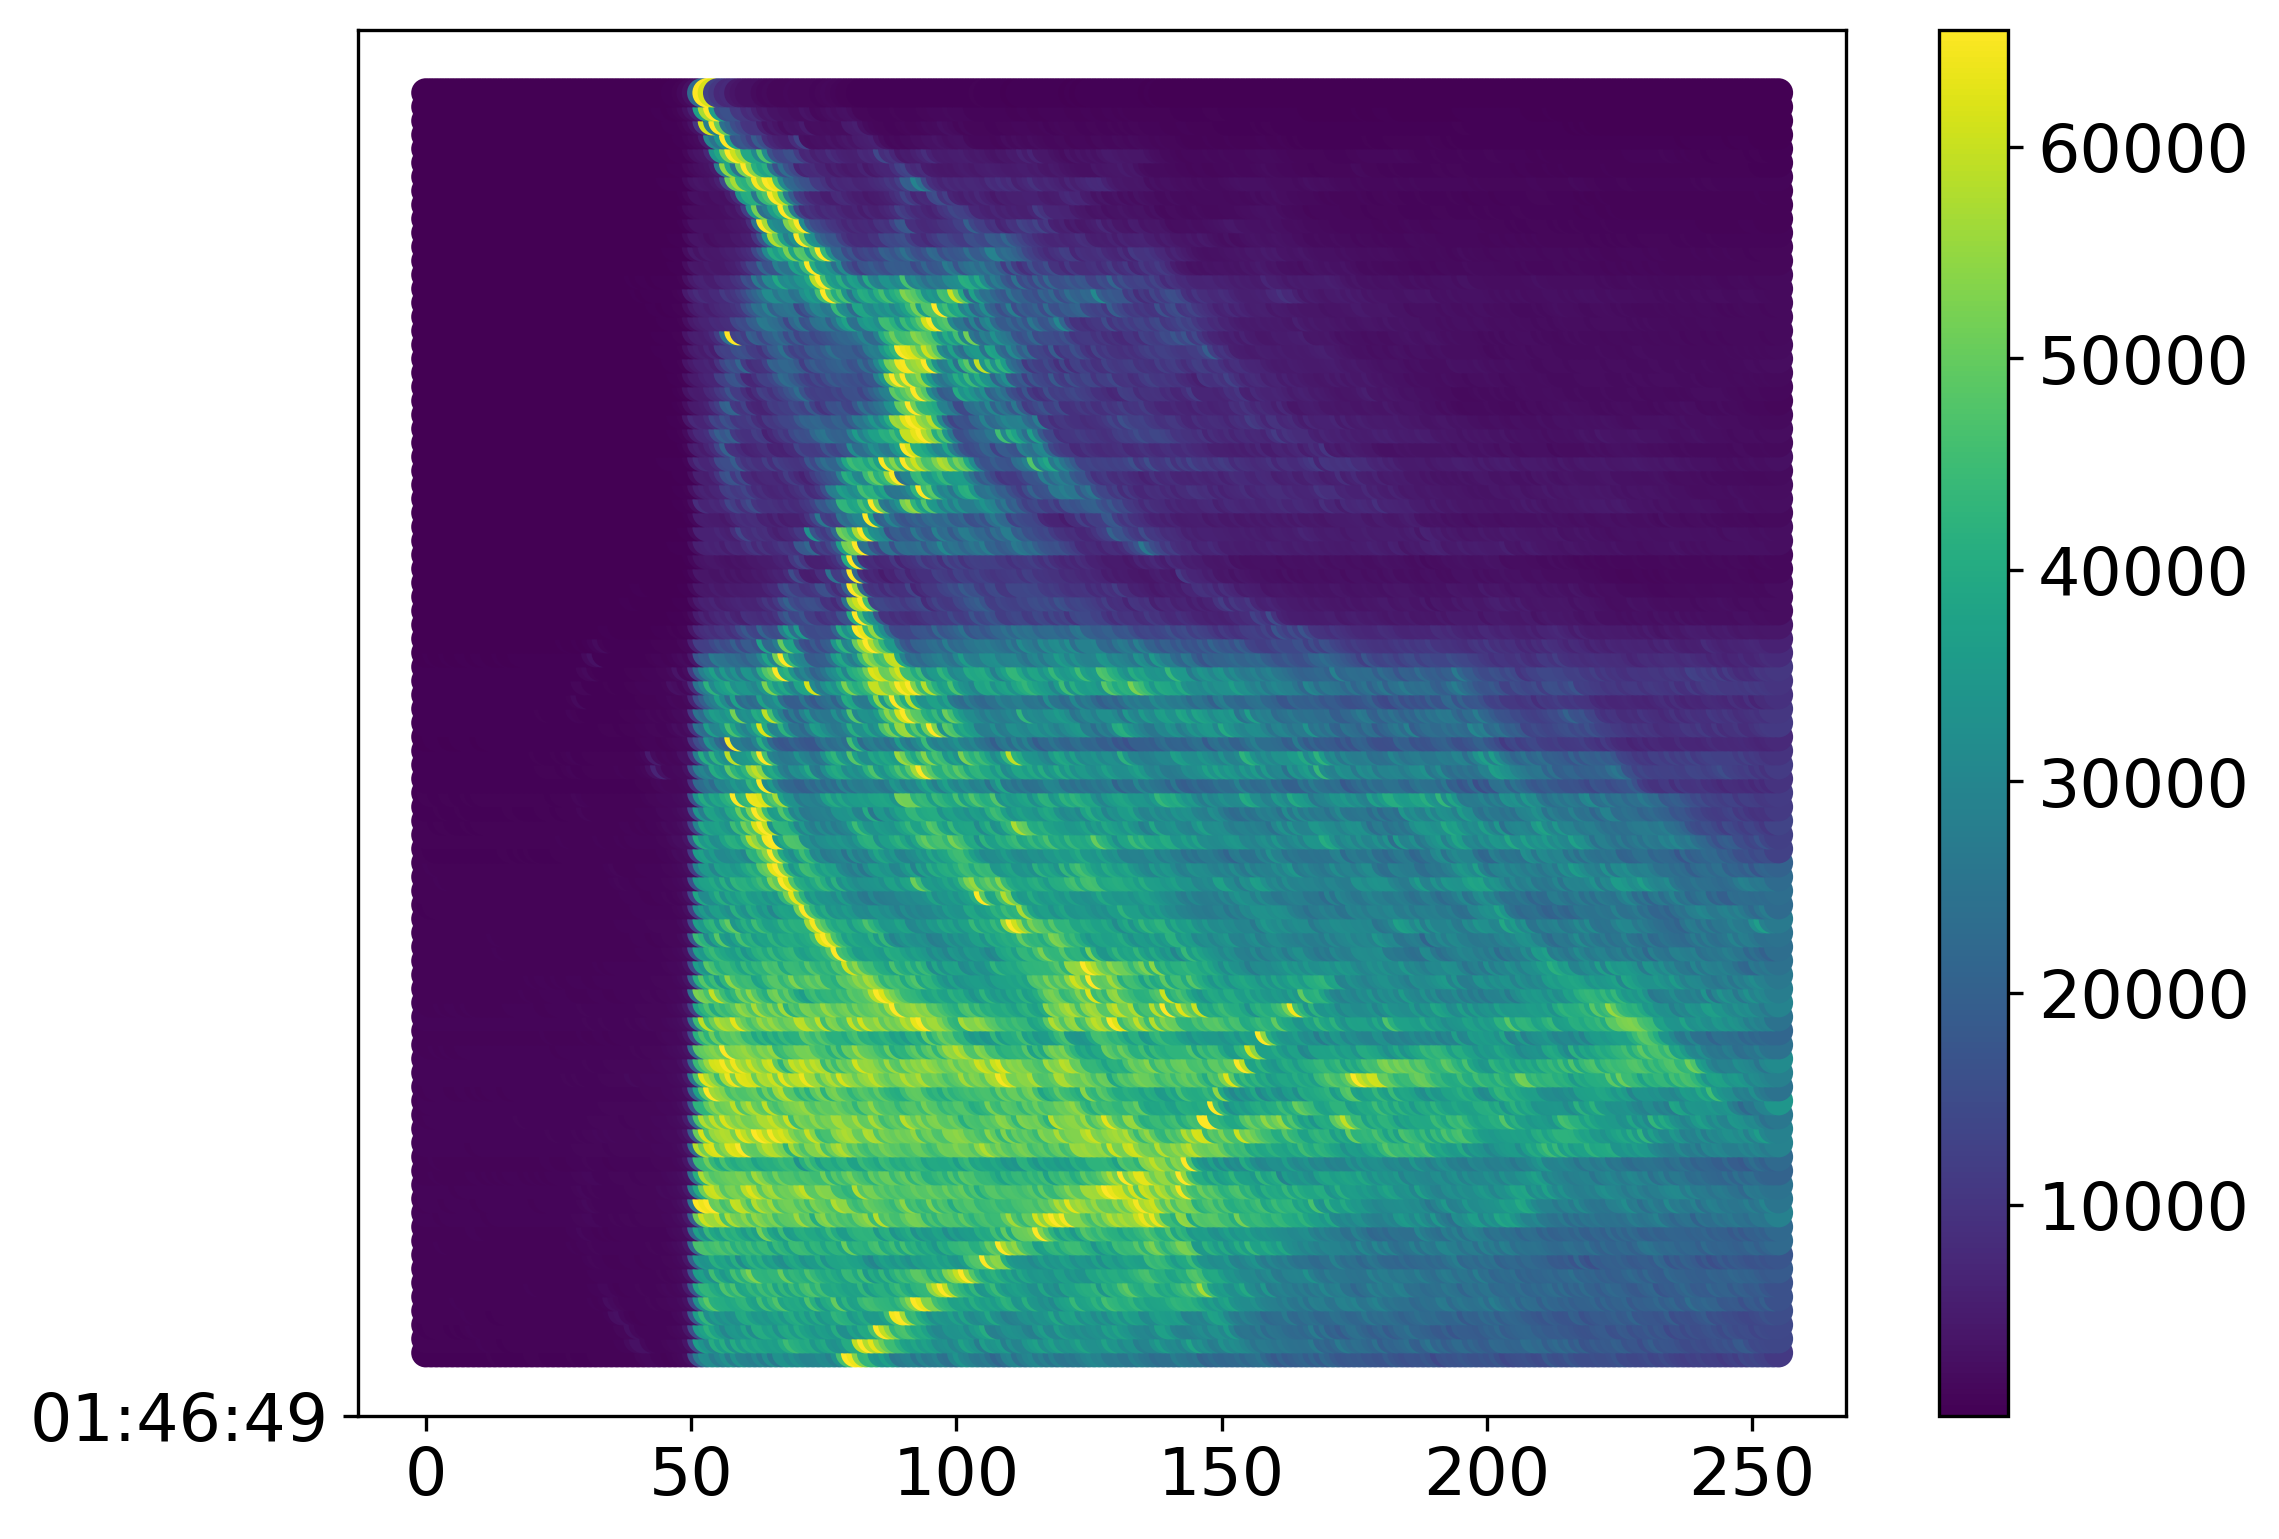

In [7]:
samples2,time2 = numpy.meshgrid(samples,time)

fig = plt.figure(figsize=(8, 6), dpi=300)
ax = plt.subplot(1,1,1)
# useful plot but not fitting our specific need (to overlay this on a map). Most often this is the kind used, though.
p1 = ax.scatter(samples2, time2, c=waveforms_20hz_ku)
#p1 = ax.pcolormesh(waveforms_20hz_ku) # is also working, index vs samples.

#colorbar
cbar = plt.colorbar(p1)

plt.show()

we need the angle of the track in order to plot the samples across it.

In [8]:
#compute the angle of the track with respect to parallels 
earth_radius = 6371000
track_direction = 0 # 01 group, ['pass_direction_flag'].data[500] or check if lat[i] > (descending, 0) or < to lat[i-1] (ascending, 1)
cwin = 2
dLon = numpy.radians(lon_20[cwin:] - lon_20[:-cwin])
dLat = numpy.radians(lat_20[cwin:] - lat_20[:-cwin])
# distance in meters along longitude ending at i (NB. dLon in radians) 
dx_before = earth_radius * dLon * numpy.cos(numpy.radians(lat_20[cwin:]))
# distance in meters along latitude, between i+1 and i (NB. dLat in radians)
dy = earth_radius * dLat

# angle relative to the equator; 
# it depends if the track is ascending (from South pole to North, latitudes increasing) or descending (from North to South)
if track_direction > 0:
    angle = numpy.arctan2(dy, dx_before)
else:
    angle = numpy.arctan2(dy, dx_before) + numpy.pi

# angle has 2 points less than the lat_20 & lon_20 array - we add indexes so as to be able to use them together, 
# even if last two points won't have a valid "angle" value
angle = angle.pad(time=(0,cwin))


Now we (arbitrarilly) define a step in lon, lat between two samples (those are supposed to be the effect of the radar wave reflection along time, not across the track, but we want to have a look at the waveforms in their geographical context).

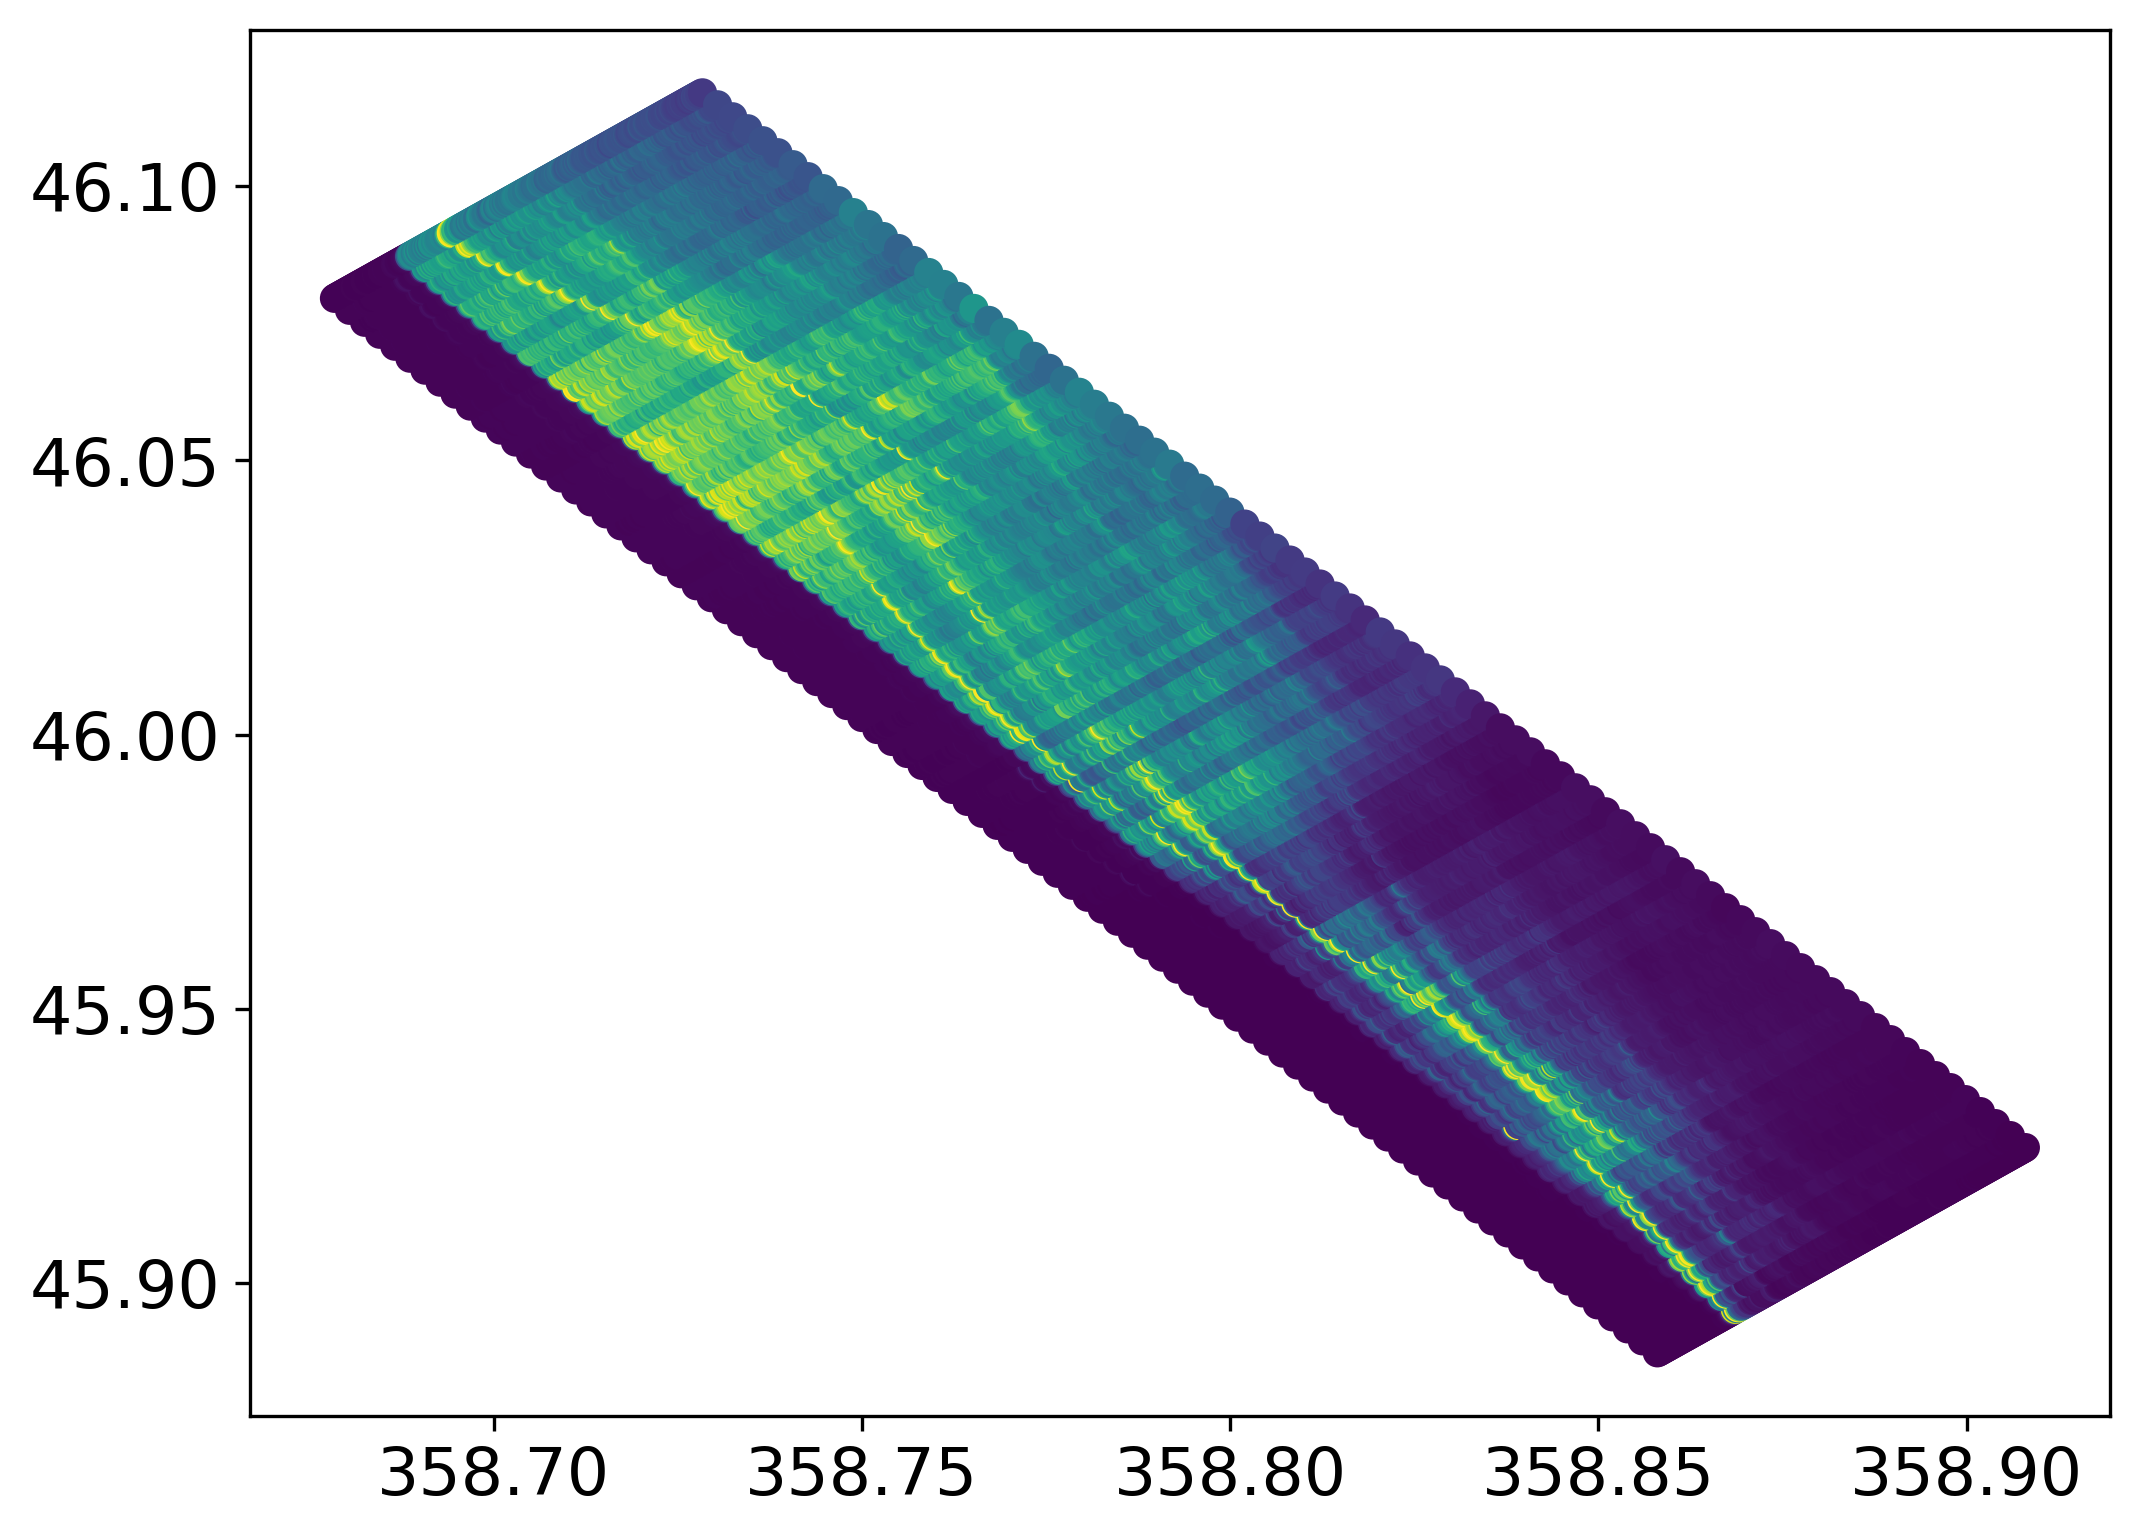

In [9]:
# we place the 128 index at lon_20[t], lat_20[t] to have the middle of our plot on the actual track (purely cosmetic)
# we plot the samples column by column, computing x and y with a tilt (angle computed, coefficients empirical)
# 1 increment ~ 0.05° 
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = plt.subplot(1,1,1)

for i in range(0,256):
#    x = lon_20 - (128-i)*0.0005*numpy.cos(numpy.radians(angle))
#    y = lat_20 - (128-i)*0.0005*numpy.sin(numpy.radians(angle))
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))

    p1 = ax.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

#plt.axis('equal')
plt.show()

Plot this on a basic map - note that this is *_not_* a real representation of the width of the radar beam.

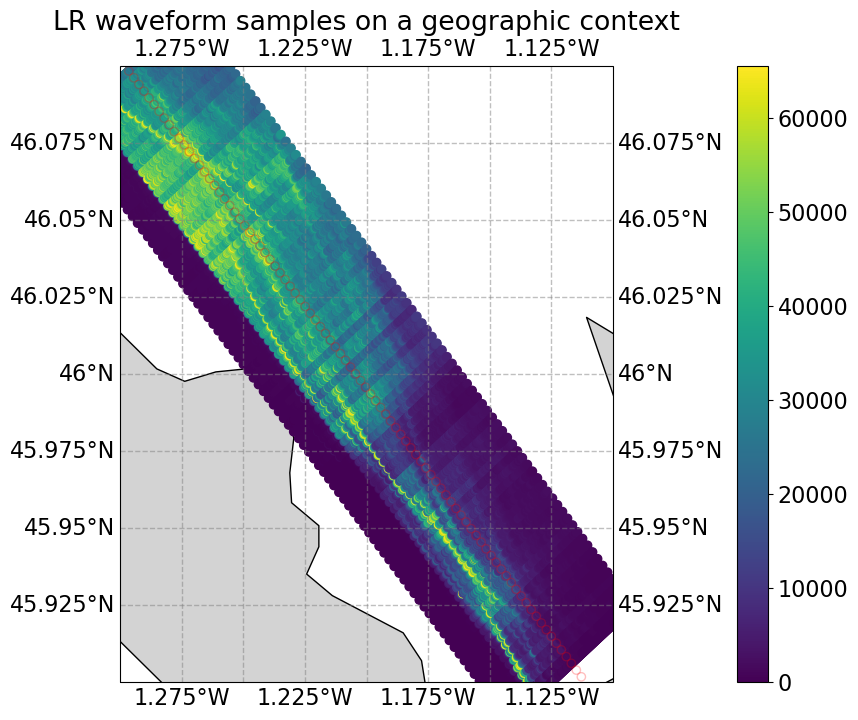

In [10]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# actually plot the data
#p1 = ax.pcolor(lon_20, lat_20, waveforms_hr_20hz_ku[:,:])
#p1 = ax.pcolor(samples, time, waveforms_hr_20hz_ku, label=' ')
# trace un point à chaque loc de forme d'onde

for i in range(0,256):
#    x = lon_20 - (128-i)*0.0005*numpy.cos(numpy.radians(angle))
#    y = lat_20 - (128-i)*0.0005*numpy.sin(numpy.radians(angle))
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))

    p1 = ax.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

#plot the actual track
p2 = ax.scatter(lon_20, lat_20, edgecolors='red', alpha=0.25, c='None')
cbar = plt.colorbar(p1, ax=ax, pad=0.1)
plt.title('LR waveform samples on a geographic context')
plt.show()


Plot the same on a high-resolution tiled background map
(NB at high zoom factors, there are no tiles over the ocean, hence possible http errors 404 and white ocean patches)

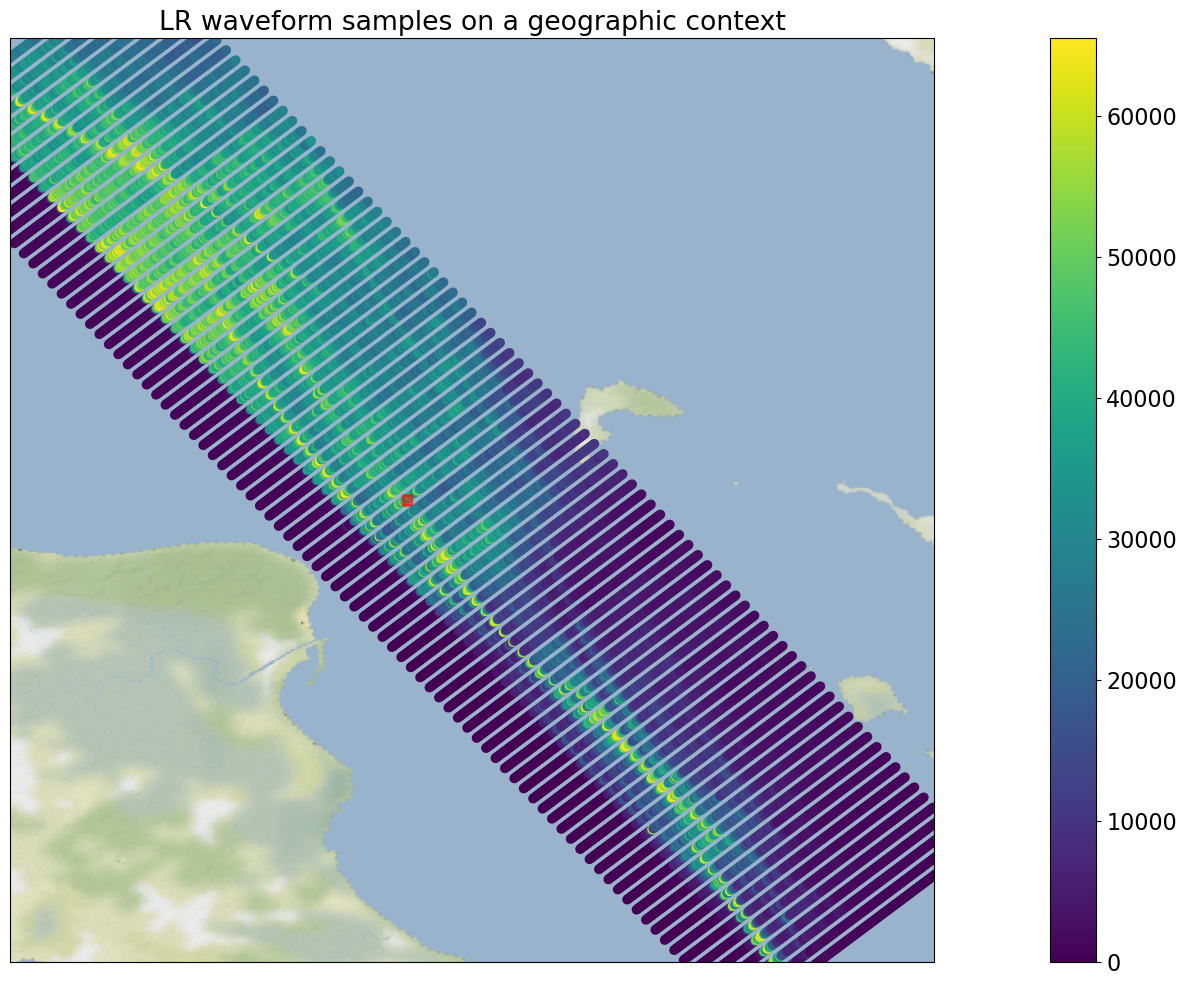

In [11]:
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

tiler = cimgt.Stamen('terrain-background')
zoom = 12
ax.add_image(tiler, zoom)

for i in range(0,256):
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))
    p1 = ax.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

lonboyard = -1.214; latboyard = 46
p2 = ax.scatter(lonboyard, latboyard, c='red', s=50, marker='s', alpha=0.5)
cbar = plt.colorbar(p1)
plt.title('LR waveform samples on a geographic context')
plt.show()


In [12]:
input_file = 'S6A_P4_1B_HR______20220410T013454_20220410T023107_20220522T154619_3373_052_070_035_EUM__REP_NT_F06.measurement.nc'

#since we consider looking at both versions of the file, we define "resolution" as HR or LR (to be used twice later on)
resolution = input_file[10:12]

my_file    = os.path.join(input_root,input_path,input_file)
nc = xr.open_dataset(my_file)
nc20kuhr = xr.open_dataset(my_file, group='data_20/ku')

if resolution=='HR':
    varsamp='samples_ov'
else:
    varsamp='samples'

sampleshr = nc.variables[varsamp]
lat_20hr_fulltrack = nc20kuhr.variables['latitude']
lon_20hr_fulltrack = nc20kuhr.variables['longitude']

In [13]:
subsetnc20kuhr = nc20kuhr.sel(time=((lon_20hr_fulltrack > lon_min) & (lon_20hr_fulltrack < lon_max) & (lat_20hr_fulltrack > lat_min) & (lat_20hr_fulltrack < lat_max)))
nc20kuhr.close()

lat_20hr = subsetnc20kuhr.variables['latitude']
lon_20hr = subsetnc20kuhr.variables['longitude']
timehr = subsetnc20kuhr.variables['time']
waveforms_20hz_kuhr = subsetnc20kuhr.variables['power_waveform']

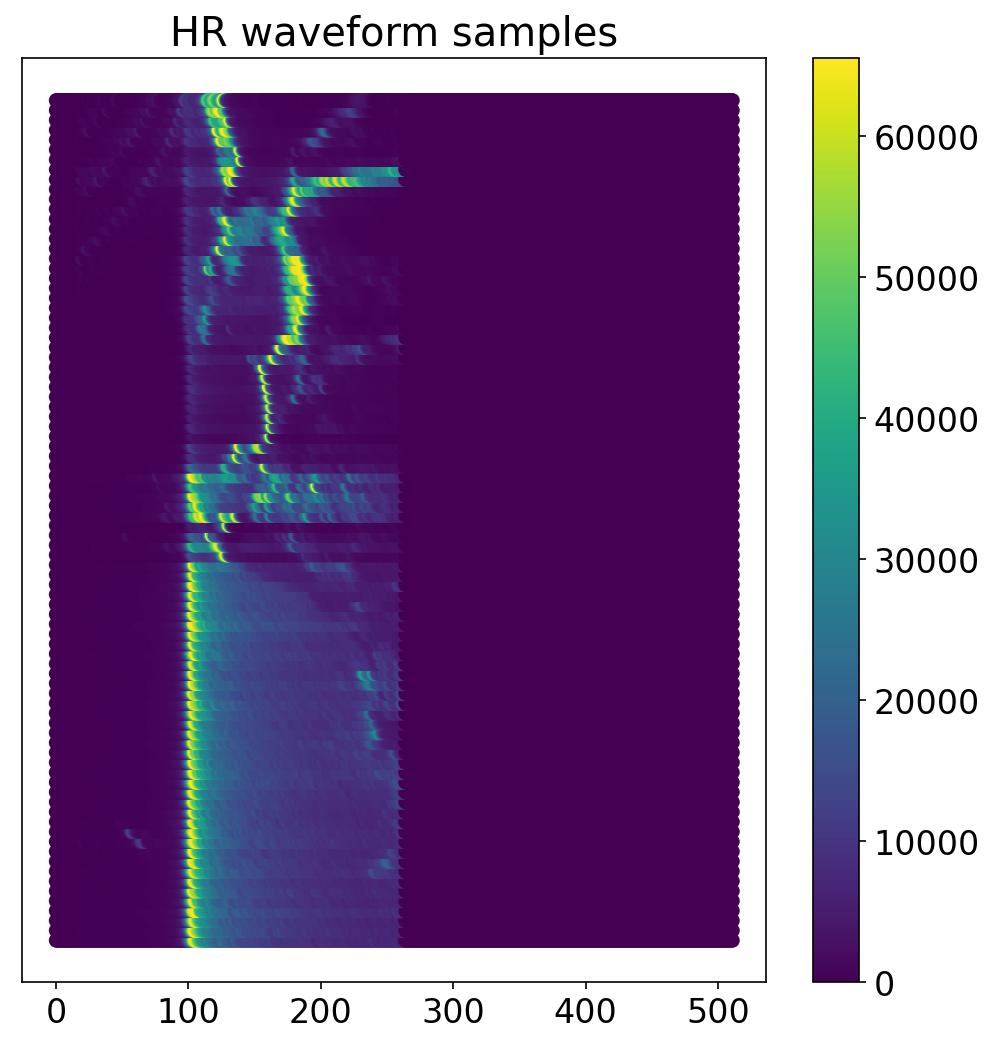

In [14]:
samples2hr,time2hr = numpy.meshgrid(sampleshr,timehr)

fig = plt.figure(figsize=(8, 8), dpi=150)
ax = plt.subplot(1,1,1)
# useful plot but not fitting our specific need (to overlay this on a map). Most often this is the kind used, though.
p2 = ax.scatter(samples2hr, time2hr, c=waveforms_20hz_kuhr)
#p1 = ax.scatter(samples2, time2, c=waveforms_20hz_ku)

#colorbar
cbar = plt.colorbar(p2)
plt.title('HR waveform samples')
plt.show()

In [15]:
#compute the angle of the track with respect to parallels 
earth_radius = 6371000
track_direction = 0 # 01 group, ['pass_direction_flag'].data[500] or check if lat[i] > (descending, 0) or < to lat[i-1] (ascending, 1)
cwin = 2
dLonhr = numpy.radians(lon_20hr[cwin:] - lon_20hr[:-cwin])
dLathr = numpy.radians(lat_20hr[cwin:] - lat_20hr[:-cwin])
# distance in meters along longitude ending at i (NB. dLon in radians) 
dx_beforehr = earth_radius * dLonhr * numpy.cos(numpy.radians(lat_20hr[cwin:]))
# distance in meters along latitude, between i+1 and i (NB. dLat in radians)
dyhr = earth_radius * dLathr

# angle relative to the equator; 
# it depends if the track is ascending (from South pole to North, latitudes increasing) or descending (from North to South)
if track_direction > 0:
    anglehr = numpy.arctan2(dyhr, dx_beforehr)
else:
    anglehr = numpy.arctan2(dyhr, dx_beforehr) + numpy.pi

# angle has 2 points less than the lat_20 & lon_20 array - we add indexes so as to be able to use them together, 
# even if last two points won't have a valid "angle" value
anglehr = anglehr.pad(time=(0,cwin))


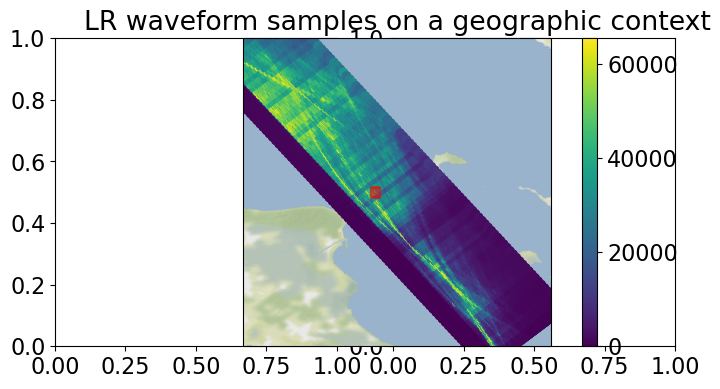

In [24]:
#fig = plt.figure(figsize=(30,12))
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax1, ax2 = axes
tiler = cimgt.Stamen('terrain-background')
zoom = 12
lonboyard = -1.214; latboyard = 46

ax1 = plt.subplot(1,2,1) 
ax1 = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax1.add_image(tiler, zoom)

for i in range(0,256):
    xhr = lon_20hr - ((128-i)/255)*0.05*numpy.cos(numpy.radians(anglehr))
    yhr = lat_20hr - ((128-i)/255)*numpy.sin(numpy.radians(anglehr))
    p6 = ax1.scatter(xhr, yhr, c=waveforms_20hz_kuhr[:,i], vmin=0., vmax=65534)

p7 = ax1.scatter(lonboyard, latboyard, c='red', s=50, marker='s', alpha=0.5)
cbar = plt.colorbar(p6, ax=ax1)
plt.title('HR waveform samples on a geographic context')

ax2 = plt.subplot(1,2,2) 
ax2 = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax2.add_image(tiler, zoom)

for i in range(0,256):
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))
    p1 = ax2.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

p2 = ax2.scatter(lonboyard, latboyard, c='red', s=50, marker='s', alpha=0.5)
cbar = plt.colorbar(p1, ax=ax2)
plt.title('LR waveform samples on a geographic context')
plt.show()


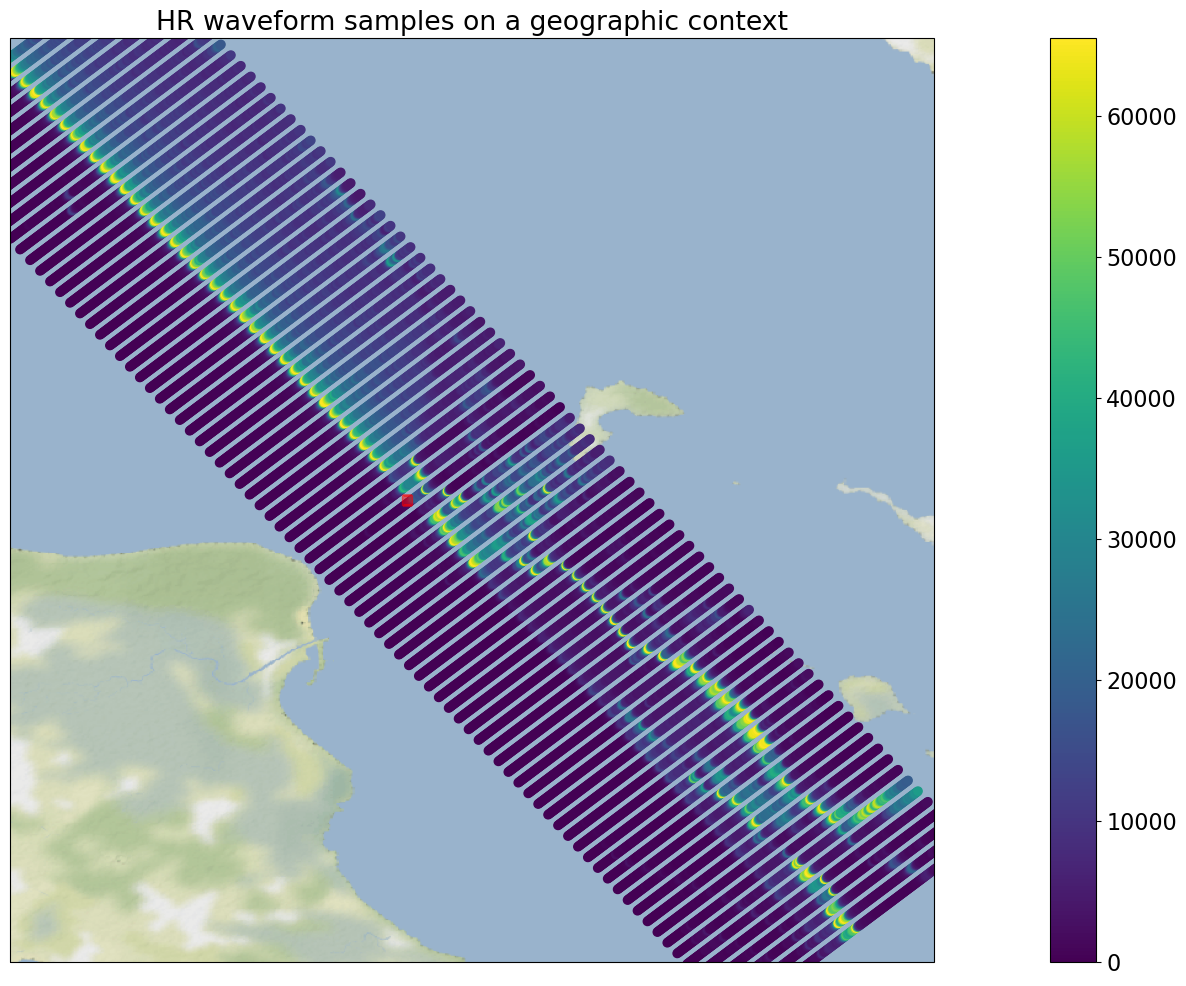

In [19]:
fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

tiler = cimgt.Stamen('terrain-background')
zoom = 12
ax.add_image(tiler, zoom)

for i in range(0,256):
    xhr = lon_20hr - ((128-i)/255)*0.05*numpy.cos(numpy.radians(anglehr))
    yhr = lat_20hr - ((128-i)/255)*numpy.sin(numpy.radians(anglehr))
    p6 = ax.scatter(xhr, yhr, c=waveforms_20hz_kuhr[:,i], vmin=0., vmax=65534)

p7 = ax.scatter(lonboyard, latboyard, c='red', s=50, marker='s', alpha=0.5)
cbar = plt.colorbar(p6, ax=ax)
plt.title('HR waveform samples on a geographic context')
plt.show()


A look in 3D. 
Notice the small peaks in the first part ("noise"), before the leading edge

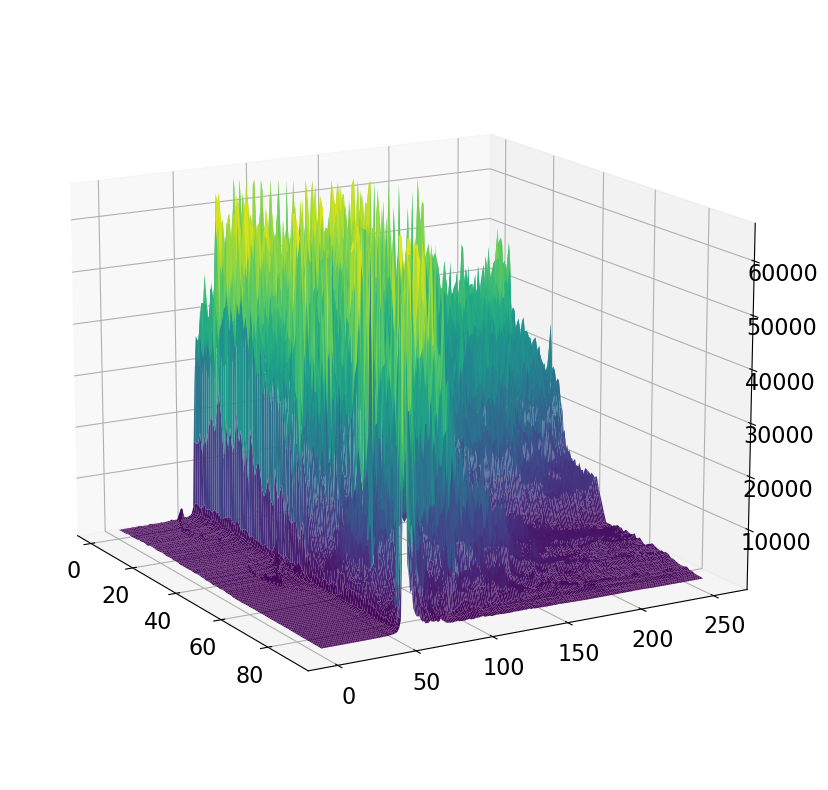

In [20]:
#3D plots need figures not time axis ??
index = list(range(time.size))
samples3,index3 = numpy.meshgrid(samples,index)

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection='3d')
ax = plt.subplot(1,1,1)

#default: ax.azim = -60; ax.dist = 10; ax.elev = 30
ax.azim = -30
ax.dist = 10
ax.elev = 15

ax.plot_surface(index3, samples3, waveforms_20hz_ku, cmap='viridis', rstride=1, cstride=1)
plt.show()

## Fort Boyard ##

We select only a few indexes around the Fort Boyard location and look at individual waveforms. 

In [21]:
lonboyard = -1.214; latboyard = 46
epsilon = 0.012 #0.0022 between two consecutive points at that latitude
subset_boyard = subsetnc20ku.sel(time=((lat_20 > latboyard - epsilon ) & (lat_20 < latboyard + epsilon)))

We will plot the waveforms left the one after the other - the things to look after are the small peaks before the leading edge. These are the effects of the radar wave bouncing on the top of the Fort Boyard before reflecting on the water. The top of the building is not a very good reflector, though, and a small one compared to the surrounding water, so those small peaks are indeed <em>small</em> - so we cut the top of the waveform off the plot, to see them better. 

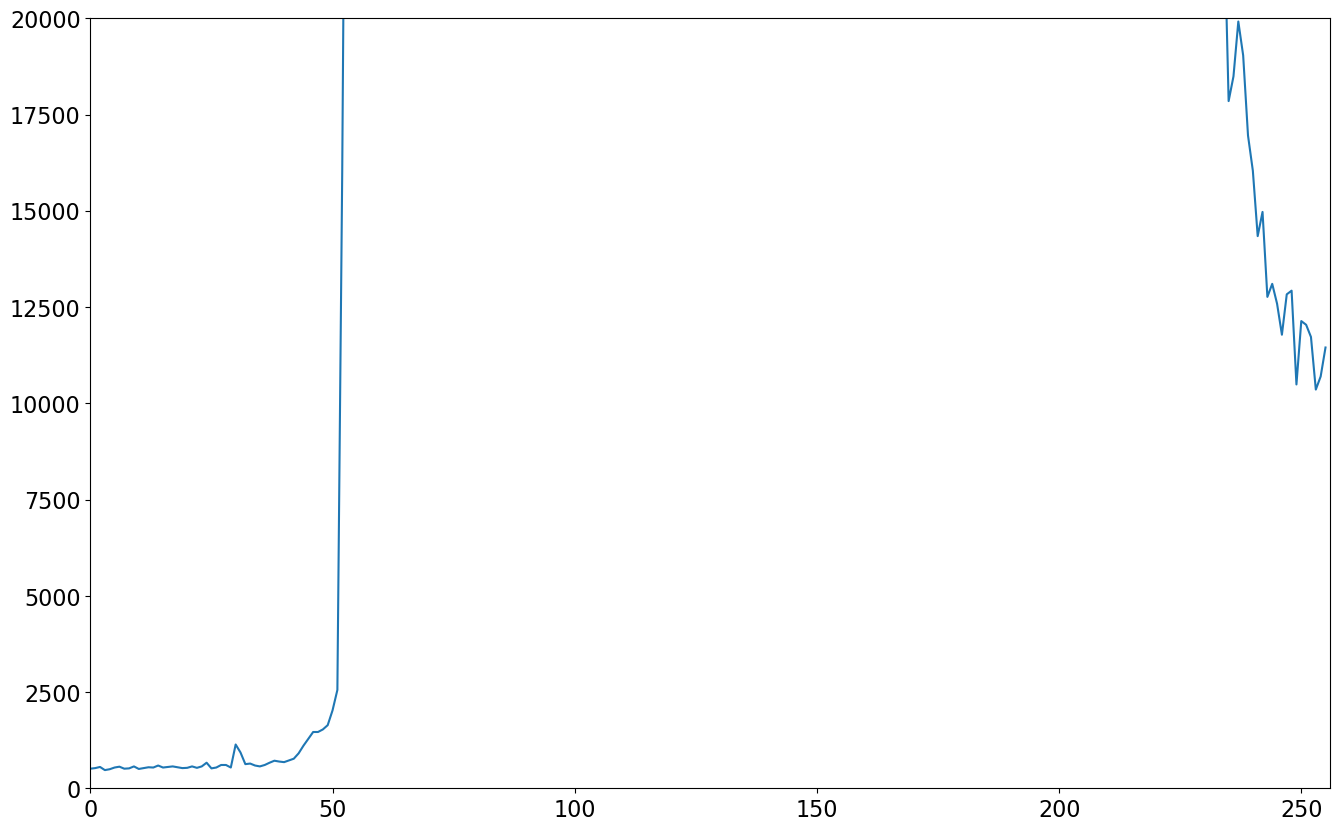

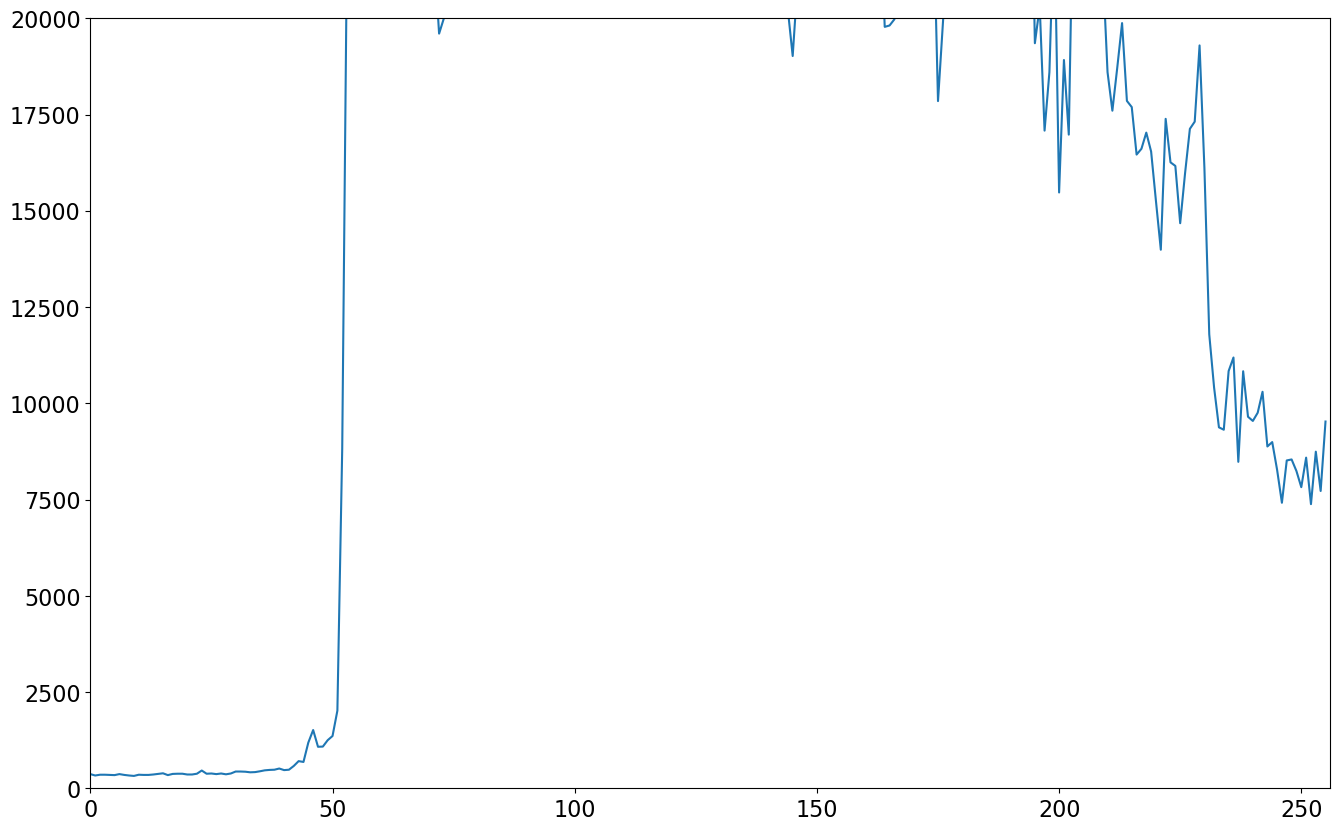

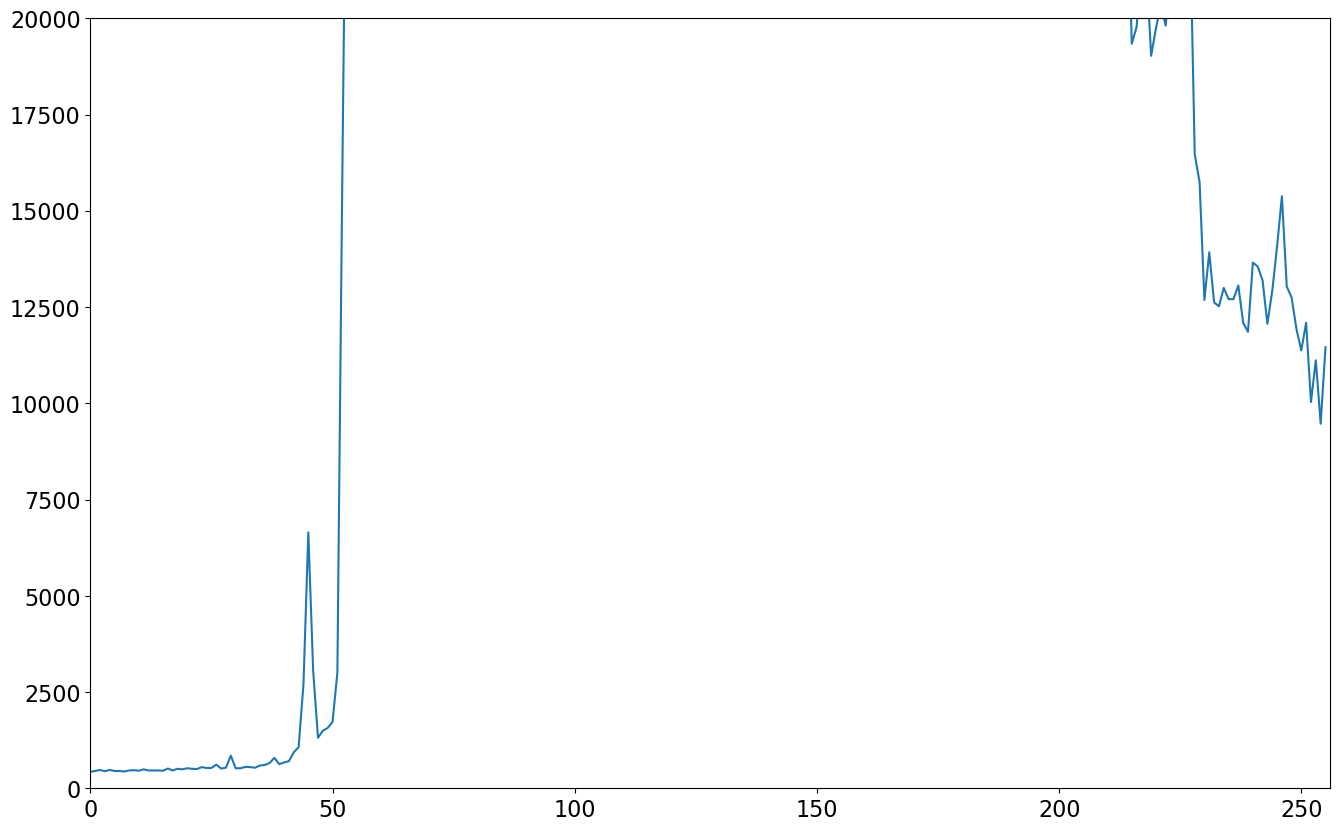

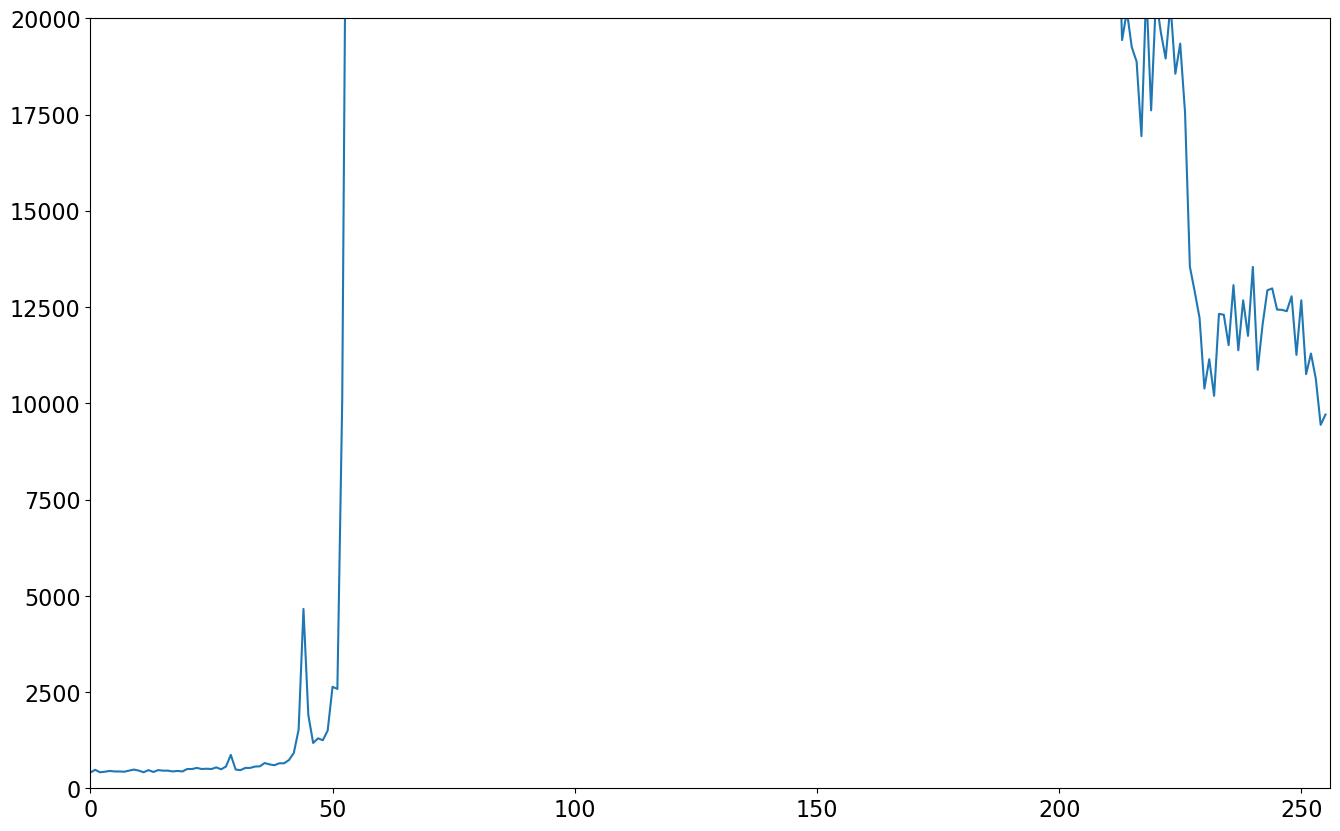

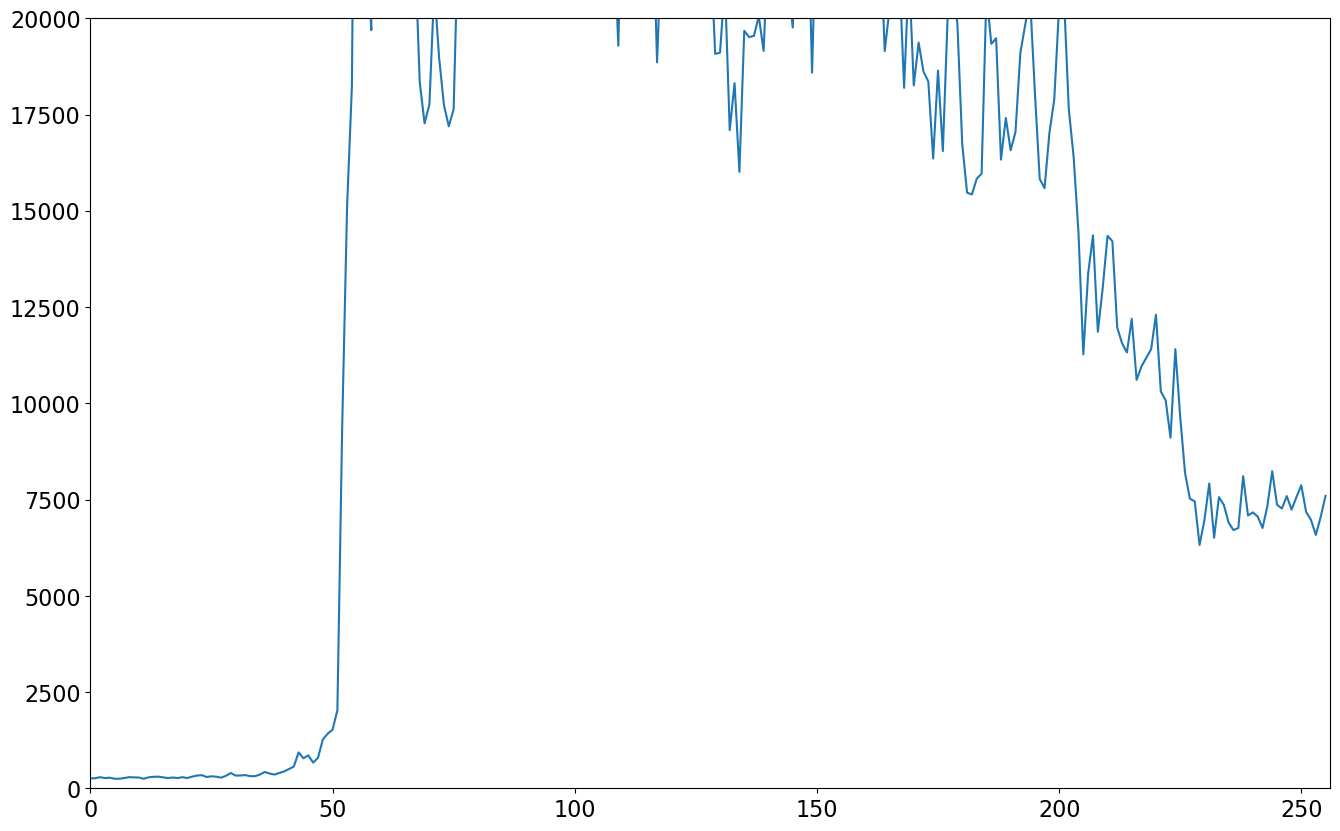

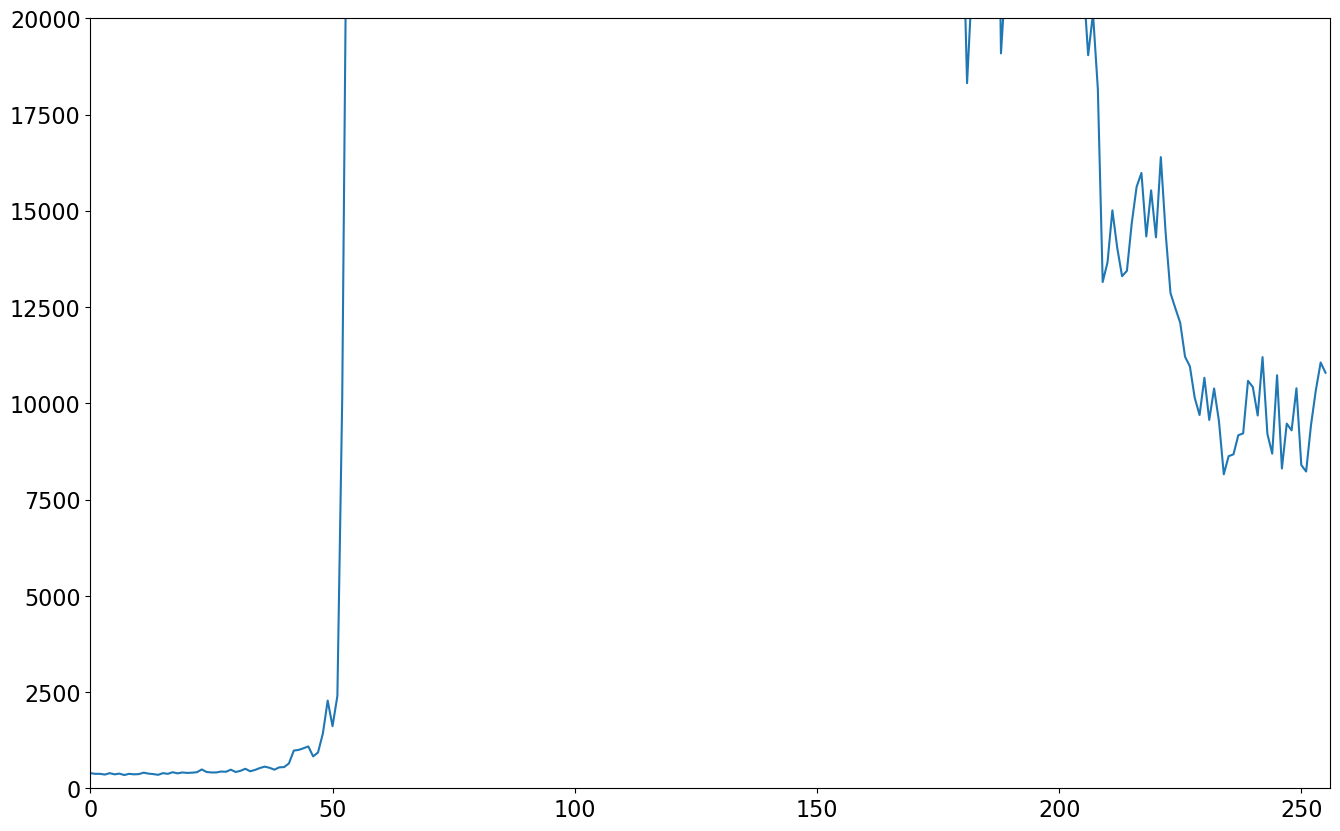

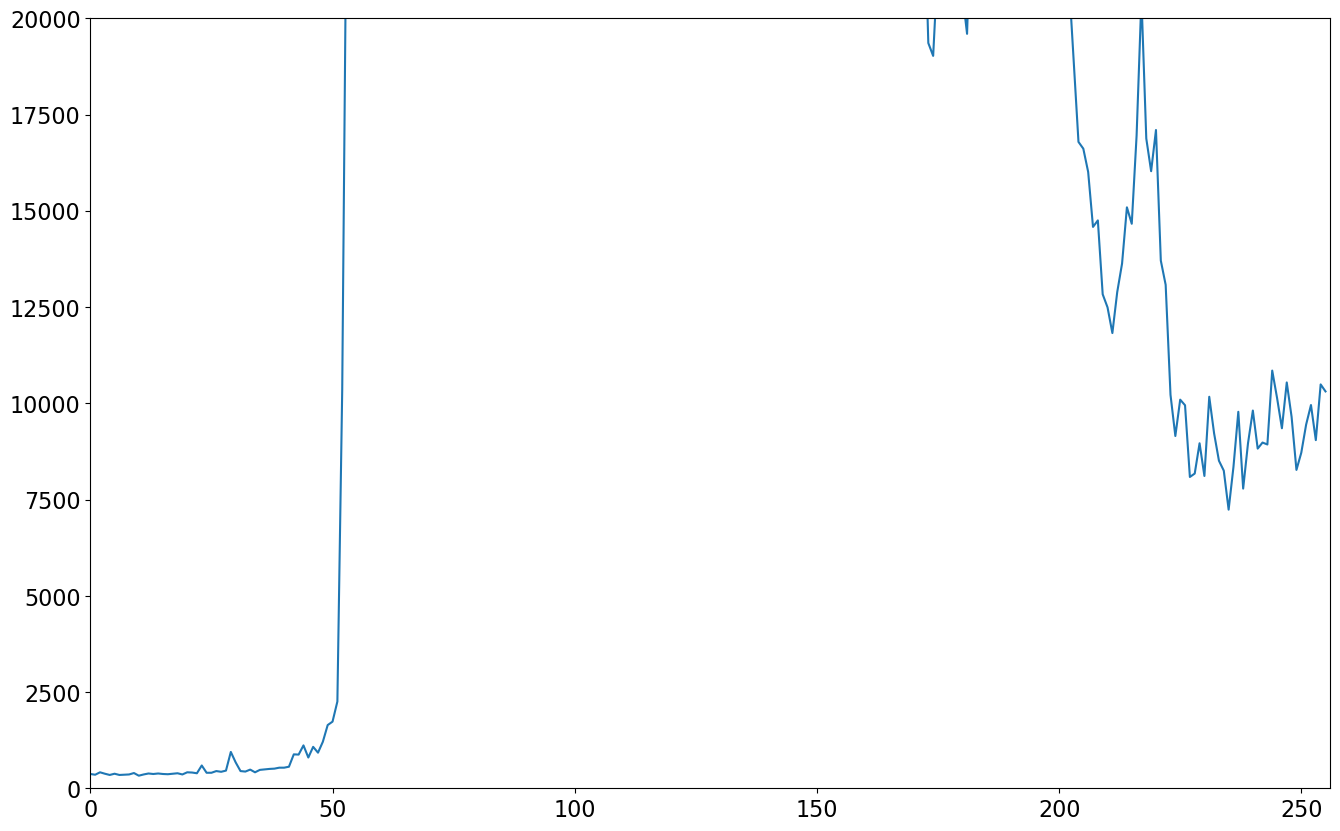

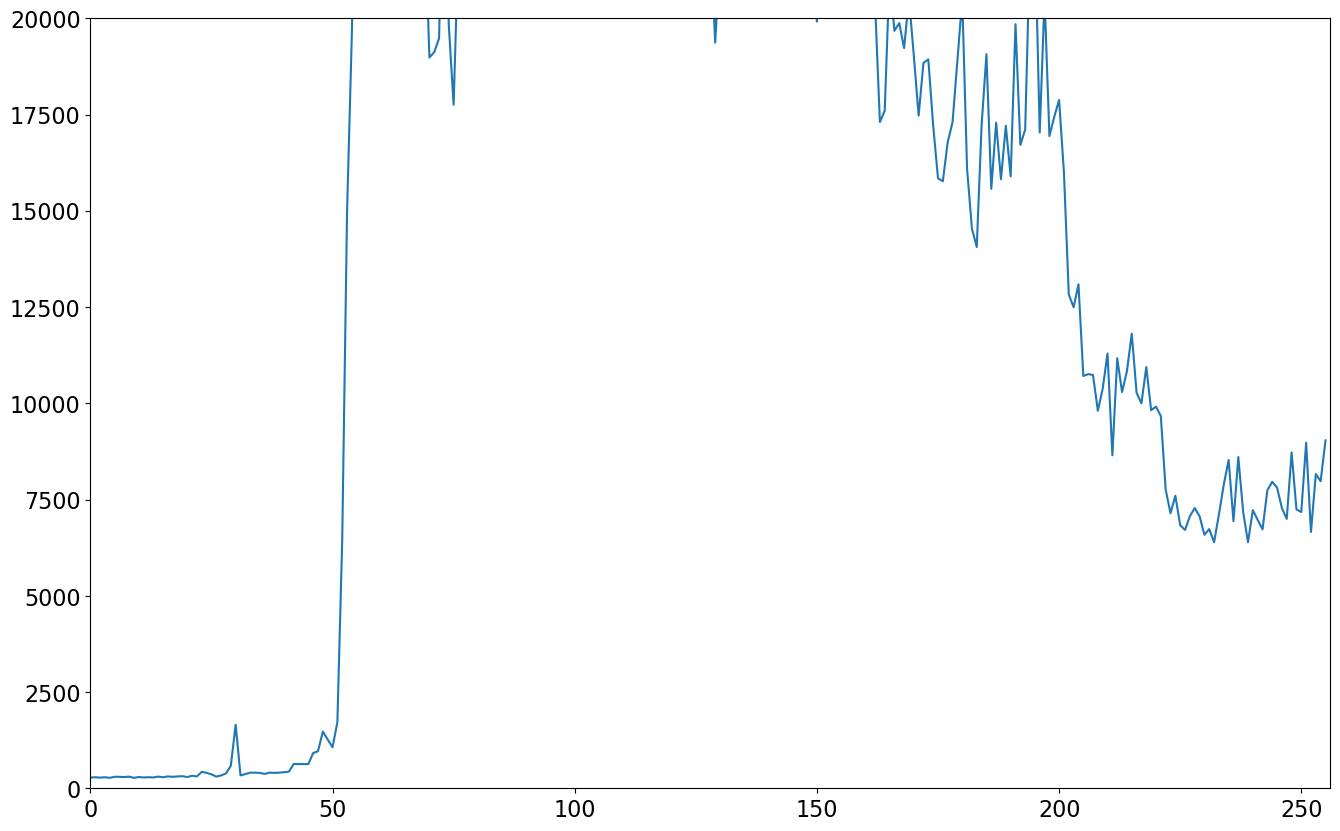

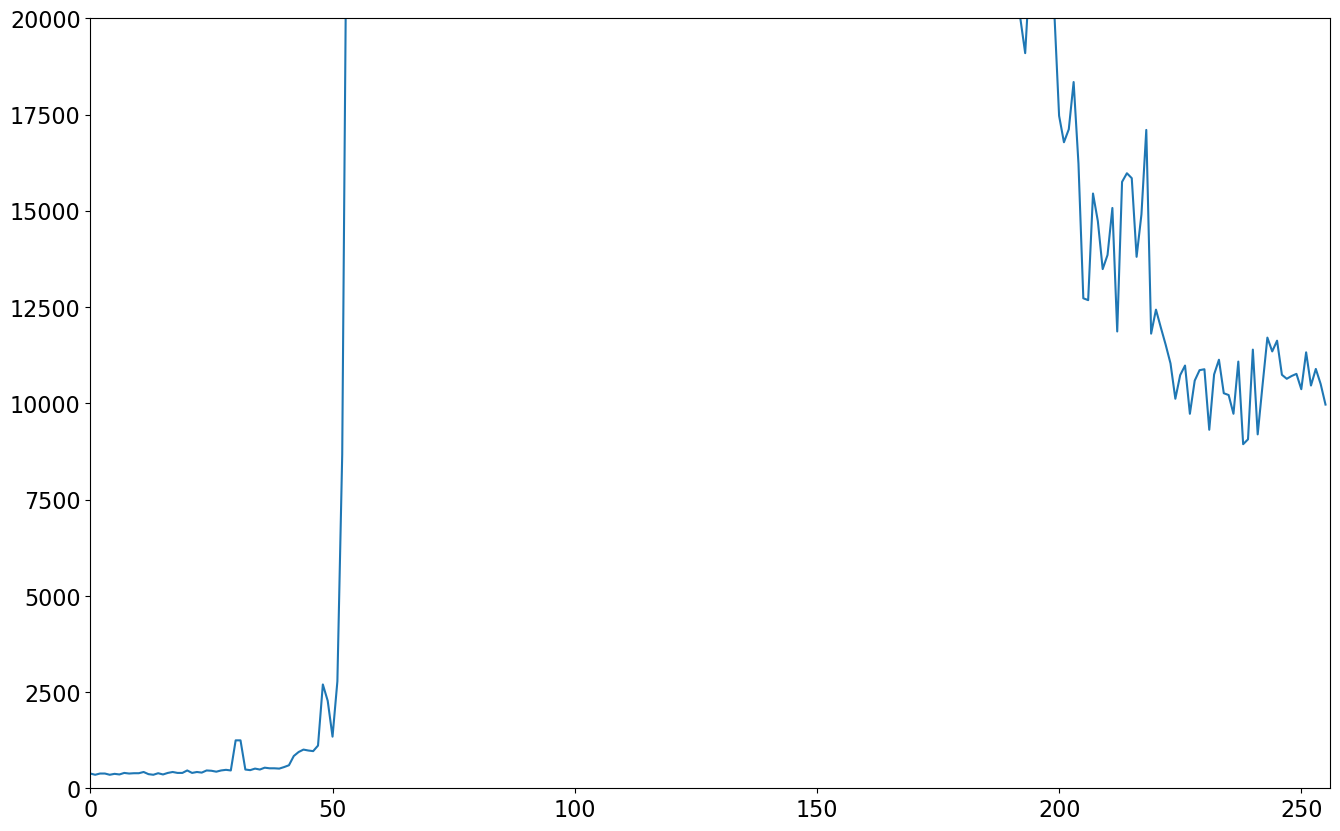

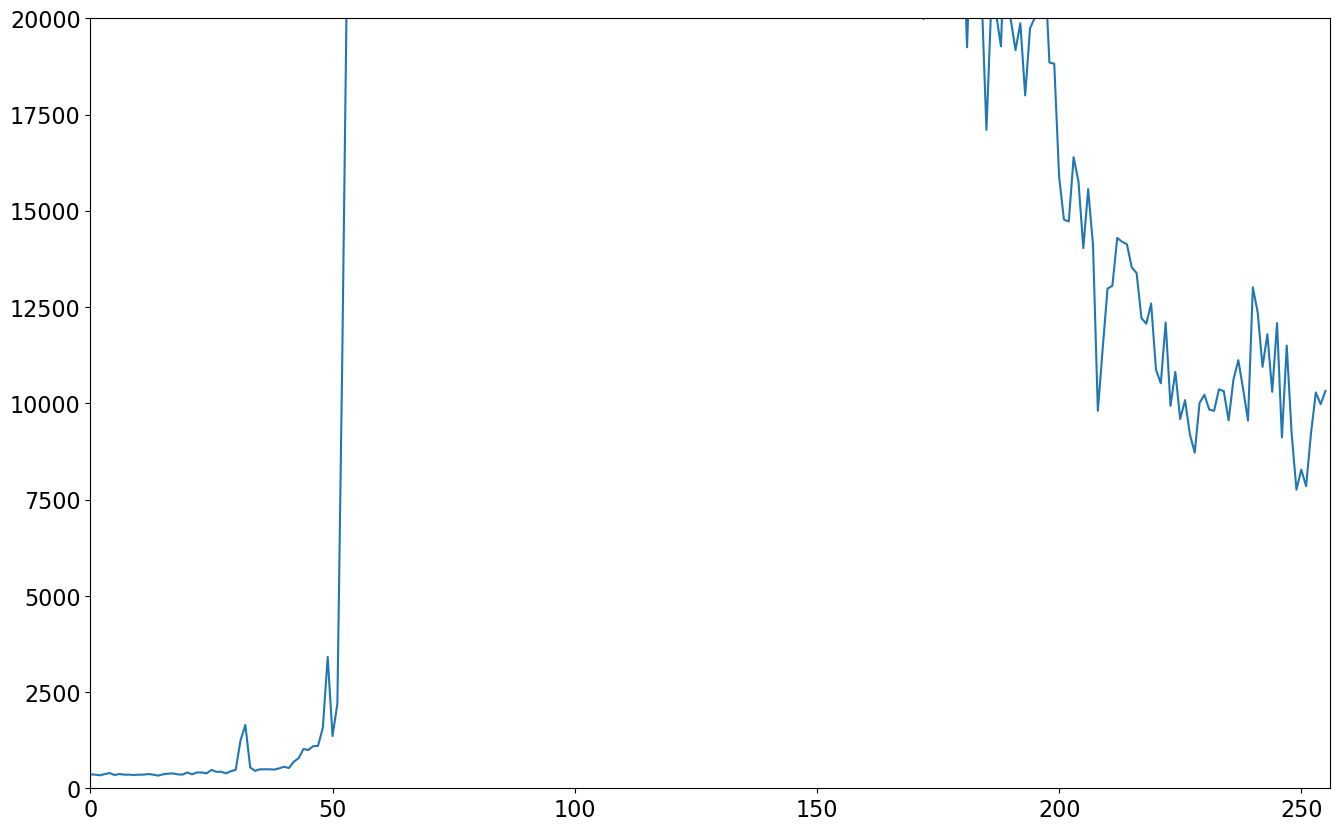

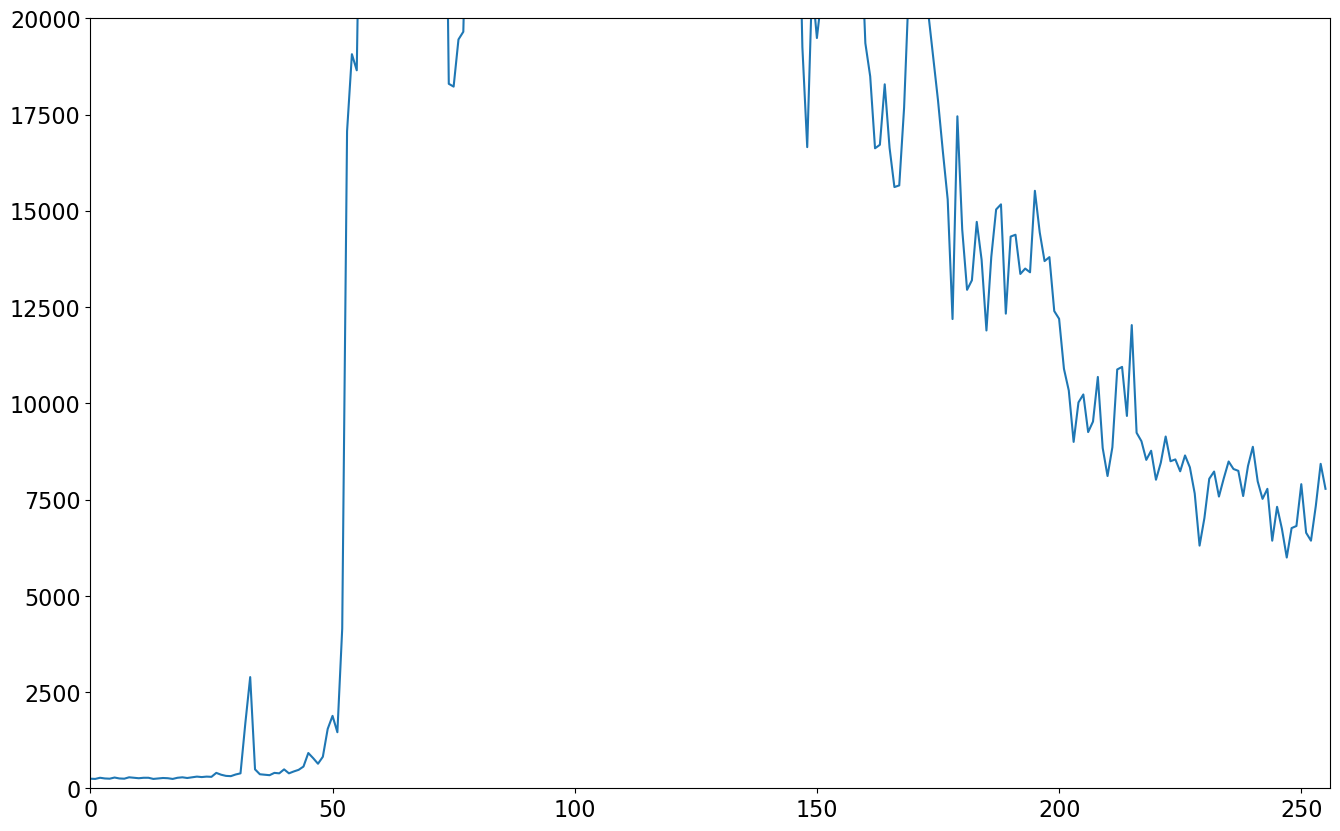

In [22]:
nbstepleft = subset_boyard.variables['time'].size

fig = plt.figure()
for index in range(0,nbstepleft):
    plt.plot(subset_boyard.variables['power_waveform'][index,:])
    plt.xlim([0, 256])
#to better view the small peak in advance, we cut the waveforms (on color plots we could have saturated the scale)
    plt.ylim([0, 20000])
    plt.savefig('S6_'+resolution+'_waveforms_fortboyard_'+str(index)+'.png')
    plt.show()